## Naive implementation

Try out a naive classical implementation based on identifying incomplete tracksters and reclustering them

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture


%matplotlib inline

from reco.matching import get_highest_energy_fraction_simtracksters
from reco.energy import get_total_energy
from reco.plotting import plot_event, plot_remapped
from reco.evaluation import evaluate, evaluate_remapped, run_evaluation
from reco.features import longest_path_from_highest_centrality, mean_edge_length, mean_edge_energy_gap
from reco.graph_utils import create_graph
from reco.event import get_bary

# file_name = "~/Data/pions/new_ntuples_14955802_7.root"
file_name = "~/data/multi/new_ntuples_14992862_991.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

Tracksters reco: 78, tracksters sim: 10
Precision: 0.97, Recall: 0.29, F-score: 0.45
Simulated energy: 3522.02, reconstructed energy: 3123.60 (88.69%)


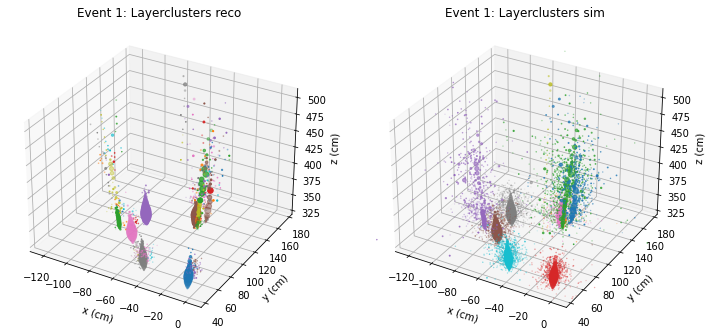

In [2]:
eid = 1

t_indexes = tracksters["vertices_indexes"].array()[eid]
t_energy = tracksters["vertices_energy"].array()[eid]
v_multi = tracksters["vertices_multiplicity"].array()[eid]
st_indexes = simtracksters["stsSC_vertices_indexes"].array()[eid]
st_energy = simtracksters["stsSC_vertices_energy"].array()[eid]
sv_multi = simtracksters["stsSC_vertices_multiplicity"].array()[eid]

print(f"Tracksters reco: {len(t_indexes)}, tracksters sim: {len(st_indexes)}")

precision, recall, fscore = evaluate(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, noise=False)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

reco_total = get_total_energy(t_energy, v_multi)
sim_total = get_total_energy(st_energy, sv_multi)
print(f"Simulated energy: {sim_total:.2f}, reconstructed energy: {reco_total:.2f} ({(reco_total / sim_total) * 100:.2f}%)")

plot_event(tracksters, simtracksters, eid, legend=False)

## Feature extraction

In [3]:
cx = tracksters["vertices_x"].array()
cy = tracksters["vertices_y"].array()
cz = tracksters["vertices_z"].array()
ce = tracksters["vertices_energy"].array()

def extract_features(_eid):
    for x, y, z, e in zip(cx[_eid], cy[_eid], cz[_eid], ce[_eid]):
        G = create_graph(x, y, z, e, N=1)
        yield (
            sum(e),
            len(e),
            longest_path_from_highest_centrality(G),
            mean_edge_length(G),
            mean_edge_energy_gap(G)
        )


features = []

# extract features from a larger dataset
for _eid in range(len(cx)):
    features += extract_features(_eid)

scaler = StandardScaler()
feat = np.array(features)
feat_s = scaler.fit_transform(feat)

Sanity check

In [4]:
# use the barycentres as seeds
X = get_bary(tracksters, eid)
kmeans = KMeans(n_clusters=len(X), init=X, n_init=1).fit(X)

evaluate_remapped(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, kmeans.labels_, noise=False)

(0.9727801513926426, 0.29287575410287714, 0.450207231172975)

## Energy based threshold

Energy seems to be the most descriptive feature for identifying incomplete tracksters.

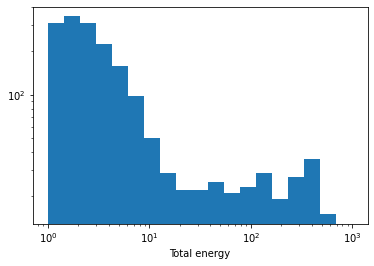

In [5]:
fig = plt.figure(figsize=(6, 4))

ax = fig.add_subplot(111)
ax.set_xlabel("Total energy")
ax.hist(feat[:,0], bins=10**np.linspace(0, 3, 20))
ax.set_yscale("log")
ax.set_xscale("log")

plt.show()

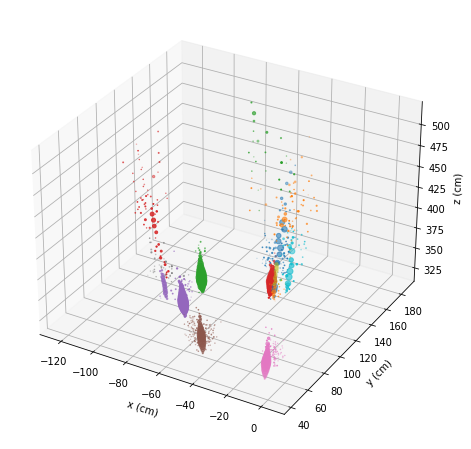

Tracksters reco: 14, tracksters sim: 10


(0.9204516701363498, 0.6447836072415382, 0.7583424124662503)

In [6]:
# only select higher energy tracksters
def eng_kmeans(tracksters, _eid, threshold=10):
    X_bary = get_bary(tracksters, _eid)
    e_data = np.array(list(extract_features(_eid)))
    seeds = X_bary[e_data[:,0] > threshold]
    kmeans = KMeans(n_clusters=len(seeds), init=seeds, n_init=1).fit(X_bary)
    return kmeans.labels_

labels = eng_kmeans(tracksters, eid)

plot_remapped(tracksters, eid, labels)

print(f"Tracksters reco: {max(labels)+1}, tracksters sim: {len(st_indexes)}")
evaluate_remapped(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, labels, noise=False)

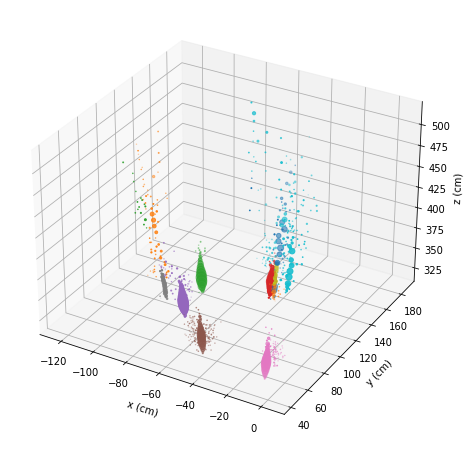

Tracksters reco: 12, tracksters sim: 10


(0.8345271671457857, 0.6492939041141484, 0.7303487097474792)

In [53]:
def eng_gmm(tracksters, _eid, threshold=25):
    X_bary = get_bary(tracksters, _eid)
    e_data = np.array(list(extract_features(_eid)))
    seeds = X_bary[e_data[:,0] > threshold]
    gmm = GaussianMixture(n_components=len(seeds), means_init=seeds, covariance_type='full').fit(X_bary)
    return gmm.predict(X_bary)

labels = eng_gmm(tracksters, eid)

plot_remapped(tracksters, eid, labels)

print(f"Tracksters reco: {max(labels)+1}, tracksters sim: {len(st_indexes)}")
evaluate_remapped(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, labels, noise=False)

## Combine features with PCA

Use the component covering the greatest variance from PCA.

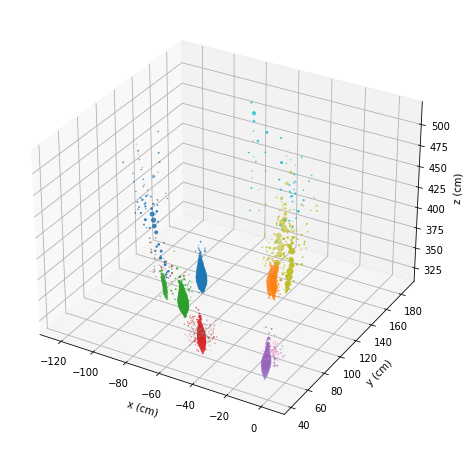

Tracksters reco: 9, tracksters sim: 10


(0.8270341948645505, 0.5851497114647862, 0.6853764843622906)

In [38]:
def pca_kmeans(tracksters, _eid, scaler=None, clf=None):
    X_bary = get_bary(tracksters, _eid)

    # compute and standardize the event features
    event_data = scaler.transform(list(extract_features(_eid)))

    # transform the event features
    data = clf.transform(event_data)

    seeds = X_bary[data[:,0] > 1]
    kmeans = KMeans(n_clusters=len(seeds), init=seeds, n_init=1).fit(X_bary)
    return kmeans.labels_

# fit PCA on all data
pca = PCA(n_components=1).fit(feat_s)
labels = pca_kmeans(tracksters, eid, scaler=scaler, clf=pca)

plot_remapped(tracksters, eid, labels)
print(f"Tracksters reco: {max(labels)+1}, tracksters sim: {len(st_indexes)}")
evaluate_remapped(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, labels, noise=False)

## Use SVM to find the best separation

In [39]:
# extract features from a larger dataset
_fractions = []

for _eid in range(len(cx)):
    reco_fr, _ = get_highest_energy_fraction_simtracksters(tracksters, simtracksters, associations, _eid)
    _fractions += reco_fr

fractions = np.array(_fractions)

In [40]:
# predict if the trackster makes up at least 2% of any simtrackster
fr_threshold = 0.02
labels = (fractions > fr_threshold).astype(int)
clf = SVC()
clf.fit(feat_s, labels)

SVC()

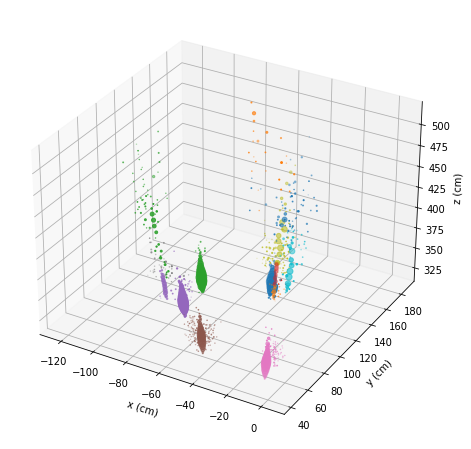

Tracksters reco: 11, tracksters sim: 10


(0.91935720834484, 0.6539270123054179, 0.764251626760625)

In [17]:
def svm_kmeans(tracksters, _eid, scaler=None, clf=None):
    X_bary = np.array([
        tracksters["barycenter_x"].array()[_eid],
        tracksters["barycenter_y"].array()[_eid],
        tracksters["barycenter_z"].array()[_eid]
    ]).T

    # compute and standardize the event features
    e_data = scaler.transform(list(extract_features(_eid)))
    
    # transform the event features
    preds = clf.predict(e_data).astype(bool)
    seeds = X_bary[preds]
    kmeans = KMeans(n_clusters=len(seeds), init=seeds, n_init=1).fit(X_bary)
    return kmeans.labels_

labels = svm_kmeans(tracksters, eid, scaler=scaler, clf=clf)

plot_remapped(tracksters, eid, kmeans.labels_)
print(f"Tracksters reco: {max(kmeans.labels_)+1}, tracksters sim: {len(st_indexes)}")
evaluate_remapped(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, kmeans.labels_, noise=False)

## Evaluation

Compare energy threshold, PCA threshold and SVM fit approaches.

In [18]:
# SVM KMEANS
run_evaluation(svm_kmeans, tracksters, simtracksters, scaler=scaler, clf=clf)

Event 0: T_reco: 10, T_sim: 10 | p: 0.83 r: 0.71 f:0.76
Event 1: T_reco: 11, T_sim: 10 | p: 0.92 r: 0.65 f:0.76
Event 2: T_reco: 15, T_sim: 10 | p: 0.94 r: 0.47 f:0.63
Event 3: T_reco: 12, T_sim: 10 | p: 0.87 r: 0.53 f:0.66
Event 4: T_reco: 16, T_sim: 10 | p: 0.90 r: 0.48 f:0.62
Event 5: T_reco: 7, T_sim: 10 | p: 0.81 r: 0.79 f:0.80
Event 6: T_reco: 11, T_sim: 10 | p: 0.92 r: 0.65 f:0.76
Event 7: T_reco: 18, T_sim: 10 | p: 0.90 r: 0.44 f:0.59
Event 8: T_reco: 9, T_sim: 10 | p: 0.64 r: 0.55 f:0.59
Event 9: T_reco: 10, T_sim: 10 | p: 0.89 r: 0.71 f:0.79
Event 10: T_reco: 13, T_sim: 10 | p: 0.83 r: 0.45 f:0.59
Event 11: T_reco: 5, T_sim: 10 | p: 0.78 r: 0.88 f:0.82
Event 12: T_reco: 11, T_sim: 10 | p: 0.81 r: 0.45 f:0.58
Event 13: T_reco: 11, T_sim: 10 | p: 0.86 r: 0.68 f:0.76
Event 14: T_reco: 12, T_sim: 10 | p: 0.98 r: 0.50 f:0.66
Event 15: T_reco: 13, T_sim: 10 | p: 0.92 r: 0.61 f:0.73
Event 16: T_reco: 8, T_sim: 10 | p: 0.83 r: 0.72 f:0.77
Event 17: T_reco: 8, T_sim: 10 | p: 0.82 r: 0

In [41]:
# PCA KMEANS
run_evaluation(pca_kmeans, tracksters, simtracksters, scaler=scaler, clf=pca)

Event 0: T_reco: 12, T_sim: 10 | p: 0.89 r: 0.55 f:0.68
Event 1: T_reco: 9, T_sim: 10 | p: 0.83 r: 0.59 f:0.69
Event 2: T_reco: 19, T_sim: 10 | p: 0.94 r: 0.41 f:0.57
Event 3: T_reco: 12, T_sim: 10 | p: 0.86 r: 0.48 f:0.61
Event 4: T_reco: 21, T_sim: 10 | p: 0.88 r: 0.39 f:0.54
Event 5: T_reco: 7, T_sim: 10 | p: 0.81 r: 0.79 f:0.80
Event 6: T_reco: 10, T_sim: 10 | p: 0.87 r: 0.62 f:0.73
Event 7: T_reco: 12, T_sim: 10 | p: 0.85 r: 0.48 f:0.62
Event 8: T_reco: 12, T_sim: 10 | p: 0.79 r: 0.50 f:0.61
Event 9: T_reco: 11, T_sim: 10 | p: 0.93 r: 0.67 f:0.78
Event 10: T_reco: 10, T_sim: 10 | p: 0.76 r: 0.51 f:0.61
Event 11: T_reco: 6, T_sim: 10 | p: 0.87 r: 0.83 f:0.85
Event 12: T_reco: 12, T_sim: 10 | p: 0.82 r: 0.42 f:0.55
Event 13: T_reco: 12, T_sim: 10 | p: 0.94 r: 0.68 f:0.79
Event 14: T_reco: 8, T_sim: 10 | p: 0.90 r: 0.61 f:0.73
Event 15: T_reco: 11, T_sim: 10 | p: 0.87 r: 0.63 f:0.73
Event 16: T_reco: 7, T_sim: 10 | p: 0.88 r: 0.78 f:0.82
Event 17: T_reco: 11, T_sim: 10 | p: 0.94 r: 0

In [44]:
# ENG Kmeans
run_evaluation(eng_kmeans, tracksters, simtracksters)

Event 0: T_reco: 8, T_sim: 10 | p: 0.73 r: 0.67 f:0.70
Event 1: T_reco: 11, T_sim: 10 | p: 0.92 r: 0.65 f:0.76
Event 2: T_reco: 13, T_sim: 10 | p: 0.92 r: 0.52 f:0.66
Event 3: T_reco: 9, T_sim: 10 | p: 0.84 r: 0.58 f:0.69
Event 4: T_reco: 14, T_sim: 10 | p: 0.89 r: 0.56 f:0.69
Event 5: T_reco: 6, T_sim: 10 | p: 0.74 r: 0.80 f:0.77
Event 6: T_reco: 8, T_sim: 10 | p: 0.86 r: 0.69 f:0.76
Event 7: T_reco: 16, T_sim: 10 | p: 0.90 r: 0.46 f:0.61
Event 8: T_reco: 9, T_sim: 10 | p: 0.64 r: 0.55 f:0.59
Event 9: T_reco: 8, T_sim: 10 | p: 0.80 r: 0.74 f:0.77
Event 10: T_reco: 9, T_sim: 10 | p: 0.80 r: 0.52 f:0.63
Event 11: T_reco: 5, T_sim: 10 | p: 0.78 r: 0.88 f:0.82
Event 12: T_reco: 11, T_sim: 10 | p: 0.81 r: 0.45 f:0.58
Event 13: T_reco: 9, T_sim: 10 | p: 0.77 r: 0.71 f:0.74
Event 14: T_reco: 12, T_sim: 10 | p: 0.98 r: 0.50 f:0.66
Event 15: T_reco: 10, T_sim: 10 | p: 0.87 r: 0.64 f:0.74
Event 16: T_reco: 7, T_sim: 10 | p: 0.80 r: 0.72 f:0.76
Event 17: T_reco: 8, T_sim: 10 | p: 0.82 r: 0.67 f:

In [54]:
# eng GMM
run_evaluation(eng_gmm, tracksters, simtracksters)

Event 0: T_reco: 8, T_sim: 10 | p: 0.66 r: 0.55 f:0.60
Event 1: T_reco: 10, T_sim: 10 | p: 0.87 r: 0.60 f:0.71
Event 2: T_reco: 13, T_sim: 10 | p: 0.95 r: 0.56 f:0.70
Event 3: T_reco: 9, T_sim: 10 | p: 0.93 r: 0.59 f:0.72
Event 4: T_reco: 12, T_sim: 10 | p: 0.83 r: 0.63 f:0.71
Event 5: T_reco: 6, T_sim: 10 | p: 0.66 r: 0.67 f:0.66
Event 6: T_reco: 8, T_sim: 10 | p: 0.66 r: 0.61 f:0.63
Event 7: T_reco: 16, T_sim: 10 | p: 0.92 r: 0.55 f:0.68
Event 8: T_reco: 9, T_sim: 10 | p: 0.82 r: 0.72 f:0.77
Event 9: T_reco: 7, T_sim: 10 | p: 0.72 r: 0.65 f:0.68
Event 10: T_reco: 7, T_sim: 10 | p: 0.77 r: 0.78 f:0.77
Event 11: T_reco: 4, T_sim: 10 | p: 0.73 r: 0.74 f:0.74
Event 12: T_reco: 11, T_sim: 10 | p: 0.90 r: 0.55 f:0.68
Event 13: T_reco: 9, T_sim: 10 | p: 0.65 r: 0.72 f:0.68
Event 14: T_reco: 11, T_sim: 10 | p: 0.93 r: 0.49 f:0.64
Event 15: T_reco: 9, T_sim: 10 | p: 0.70 r: 0.61 f:0.65
Event 16: T_reco: 7, T_sim: 10 | p: 0.78 r: 0.69 f:0.73
Event 17: T_reco: 8, T_sim: 10 | p: 0.84 r: 0.65 f:0